# 1. Install Necessary Libraries

In [31]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

# 2. Import necessary dependencies and set environment variables

In [32]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")



In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

Autonomy: They can act independently and make decisions.

Proactiveness: They can initiate actions and pursue goals.

Adaptability: They can learn and adapt to changes in their environment.

Goal-Oriented Behavior: They strive to achieve specific objectives or fulfill a particular purpose.

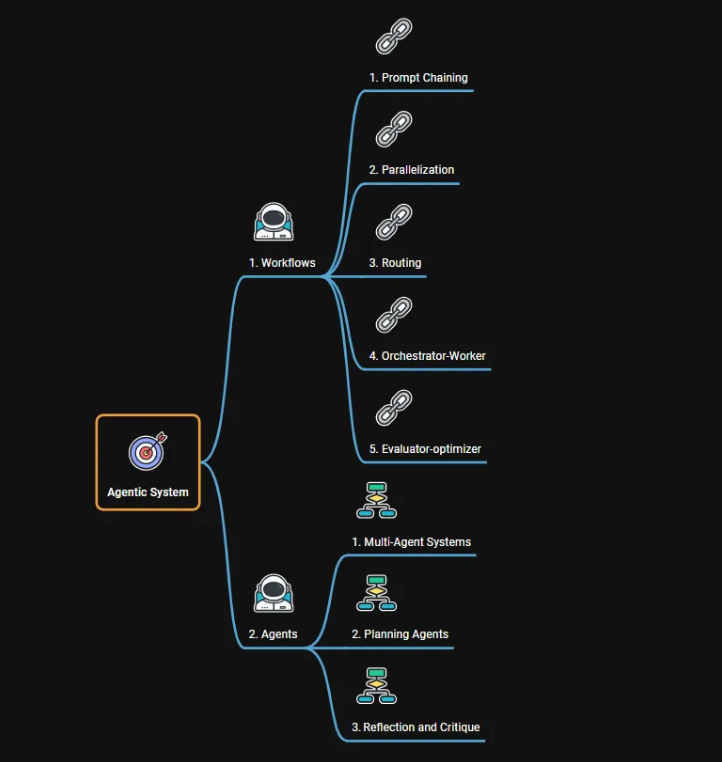

Detailed Blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. Agents - Planning Agents (Reasoning without observation)

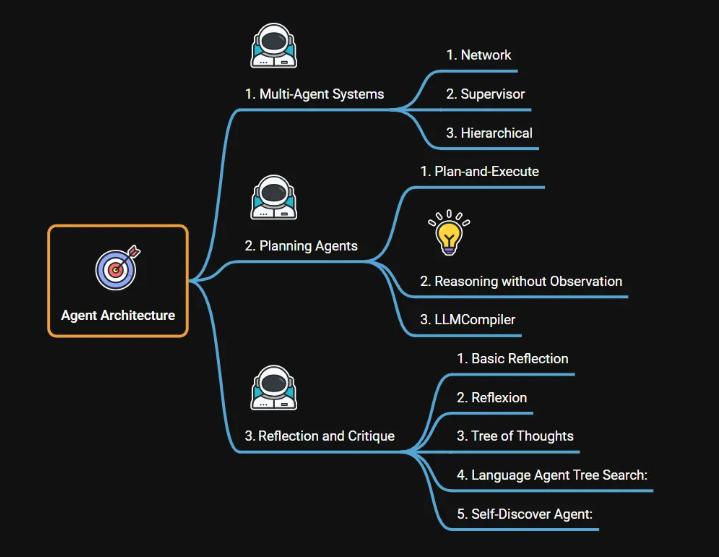

Detailed Blog : https://aiproductplaybook.substack.com/p/1011-what-the-heck-are-reasoning

a. Reasoning without observation

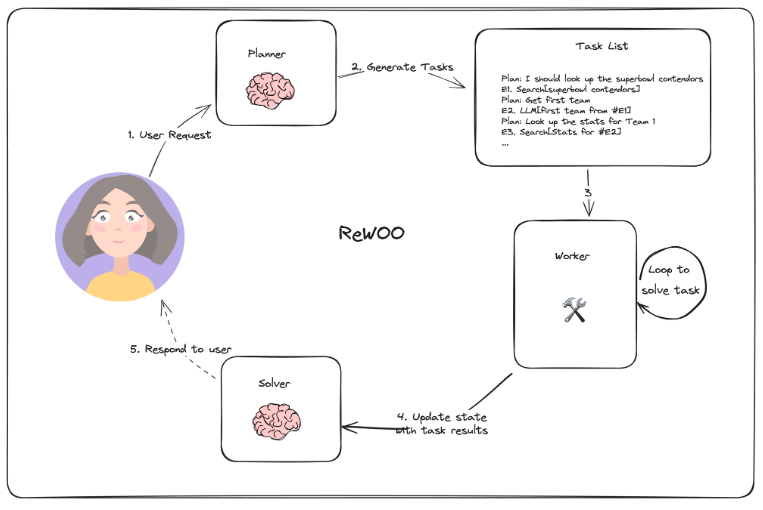

### b. Define the states

1. Import dependencies

2. ReWOO TypedDict

This defines the ReWOO type.  Any dictionary that is supposed to conform to this type must have the following keys with the specified value types:

a. task: str: A string representing the overall task or objective.

b. plan_string: str: A string containing a textual representation of the plan. This is likely a human-readable version of the plan.

c. steps: List: A list. The type of the elements in the list is not specified, so it could contain anything. It is likely a list of individual steps in the plan, where each step could be a string, a dictionary, or some other data structure.

d. results: dict: A dictionary. This is probably intended to store the results of executing each step in the plan. The keys of the dictionary would likely correspond to the steps or some identifier for each step, and the values would be the results of those steps.

e. result: str: A string representing the final result or outcome of the entire process.

The ReWOO TypedDict defines a structure for storing information related to a process that involves a task, a plan (both as a string and a list of steps), the results of executing those steps, and the final result. This structure is useful for organizing and type-hinting the data associated with a workflow or a reasoning process, particularly one that involves observation and output, as the name suggests.  The unspecified type for the steps list provides flexibility in how individual steps are represented.

In [55]:
from typing import List
from typing_extensions import TypedDict


class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

### c. Define the Planner prompt

In [51]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")

In [52]:
prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) Google[input]: Worker that searches results from Google. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha. #E1 = WolframAlpha[Solve x + (2x − 10) + ((2x − 10) − 8) = 157]
Plan: Find out the number of hours Thomas worked. #E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked. #E3 = Calculator[(2 ∗ #E2 − 10) − 8]

Begin!
Describe your plans with rich details. Each Plan should be followed by only one #E.

Task: {task}"""

In [53]:
task = "what is the exact hometown of the 2024 mens australian open winner"
result = model.invoke(prompt.format(task=task))
print(result.content)

To determine the exact hometown of the winner of the 2024 Men's Australian Open, I will create a series of plans that involve searching for the winner's name and then verifying their hometown.

Plan: First, I will conduct a Google search to find out the name of the winner of the 2024 Men's Australian Open. This will give us the necessary information to proceed further. #E1 = Google[2024 Men's Australian Open winner]

Plan: Next, I will search for the hometown of the player identified as the winner in the first step. This will help pinpoint their exact hometown. #E2 = Google[hometown of #E1]

Plan: Finally, I will summarize the findings and confirm the exact hometown of the 2024 Men's Australian Open winner for clarity and accuracy. #E3 = LLM[Provide a summary of the winner's hometown found in #E2] 

By following these steps in this order, I can efficiently gather the required information.


### d. Define the planner node

1. Import necessary dependencies

2. Regular Expression Pattern

This line defines a regular expression pattern. Let's dissect it:

r"...": Indicates a raw string, which is helpful for regular expressions as it avoids the need to escape backslashes.

Plan:\s*: Matches the literal string "Plan:" followed by zero or more whitespace characters (\s*).

(.+): Matches one or more of any character (except newline). This is the first capturing group and will capture the description of the step.

\s*: Matches zero or more whitespace characters.

(#E\d+): Matches a string that starts with "#E" followed by one or more digits (\d+). This is the second capturing group and is likely an ID or label for the step (e.g., #E1, #E2).

\s*=\s*: Matches zero or more whitespace characters, followed by an equals sign, followed by zero or more whitespace characters.

(\w+): Matches one or more alphanumeric characters (and underscore). This is the third capturing group and probably represents the tool or function to be used for this step.

\s*: Matches zero or more whitespace characters.

\[([^\]]+)\]: Matches a string enclosed in square brackets. [^\]]+ matches one or more characters that are not a closing square bracket. This is the fourth capturing group and likely contains the input or parameters for the tool/function.

In essence, this regular expression is designed to parse lines that look like below :

Plan: Step description #E1 = tool_name [tool_input]

3. Prompt Template and Planner

a. prompt_template = ChatPromptTemplate.from_messages([("user", prompt)]): Creates a ChatPromptTemplate with a single user message. The prompt variable (which is not defined in this snippet) is assumed to be a string containing the prompt to be sent to the language model. This prompt likely asks the LLM to generate a plan.

b. planner = prompt_template | model: Creates a planner object. This combines the prompt template with a language model (model, which is assumed to be defined elsewhere). The pipe operator (|) chains the prompt template and the model together. When planner.invoke() is called, the prompt will be formatted and then sent to the language model.

4. Define get_plan Function

a. def get_plan(state: ReWOO): Defines a function get_plan that takes a state (of type ReWOO, which was defined in your previous code) as input.

b. task = state["task"]: Extracts the task from the state.

c. result = planner.invoke({"task": task}): Calls the planner (the LLM with the prompt) to generate a plan for the given task. The output of the LLM is stored in the result object.

d. matches = re.findall(regex_pattern, result.content): Uses re.findall() to find all occurrences of the regex_pattern in the LLM's response (result.content). re.findall() returns a list of tuples, where each tuple corresponds to a match and contains the captured groups.

e. return {"steps": matches, "plan_string": result.content}: Returns a dictionary containing the extracted steps (the list of tuples from the regex matches) and the raw plan_string (the LLM's full response).


Summary

The get_plan function uses a language model to generate a plan for a given task and then uses a regular expression to parse the structured plan from the LLM's response. The parsed plan (the list of steps) and the original plan string are returned. This function is likely part of a larger system that uses LLMs for planning and execution. The regular expression parsing allows the system to reliably extract the individual steps and their associated information from the LLM's output.

In [56]:
import re

from langchain_core.prompts import ChatPromptTemplate

# Regex to match expressions of the form E#... = ...[...]
regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
planner = prompt_template | model


def get_plan(state: ReWOO):
    task = state["task"]
    result = planner.invoke({"task": task})
    # Find all matches in the sample text
    matches = re.findall(regex_pattern, result.content)
    return {"steps": matches, "plan_string": result.content}

### e. Define the executor node

1. Import necessary dependencies

2. Initialize tavily search

3. _get_current_task(state: ReWOO) Function

a. This helper function determines the index of the next task to be executed.

b. It takes the state (of type ReWOO, defined in your previous code) as input.

c. Logic:

If the results key is not in the state or the results dictionary is None, it means no tasks have been executed yet, so it returns 1 (the first task).

If the number of results in state["results"] is equal to the number of steps in state["steps"], it means all tasks have been completed, so it returns None.

Otherwise, it returns the index of the next task to be executed, which is len(state["results"]) + 1.

4. tool_execution(state: ReWOO) Function

a. This function executes a tool based on the plan.

b. It takes the state (of type ReWOO) as input.

c. _step = _get_current_task(state): Calls the helper function to get the index of the current task.

d. _, step_name, tool, tool_input = state["steps"][_step - 1]: Retrieves the step details (name, tool, and input) from the steps list in the state. Note that it uses _step - 1 because list indices are 0-based.

e. _results = (state["results"] or {}) if "results" in state else {}: Gets the existing results from the state or initializes an empty dictionary if no results exist yet.

f. The code then iterates through the existing results. For each key-value pair in the _results dictionary, it replaces occurrences of the key (which would be a step name) in the tool_input string with the corresponding value (the result of that step). This allows for chaining of results between steps.

g. Tool Execution:

if tool == "Google":: If the tool is "Google", it uses the search.invoke() method (from the TavilySearchResults class) to perform a web search.

elif tool == "LLM":: If the tool is "LLM", it uses model.invoke() (where model is assumed to be a language model instance) to call the language model.

else: raise ValueError: If the tool is neither "Google" nor "LLM", it raises a ValueError.

_results[step_name] = str(result): Stores the result of the tool execution in the _results dictionary, using the step name as the key. The result is converted to a string.

return {"results": _results}: Returns a dictionary containing the updated results.

Summary

The tool_execution function executes a single step from a plan. It determines the correct step, retrieves the tool and input for that step, substitutes previous results into the input, executes the specified tool (either a web search or a language model call), and stores the result.  The _get_current_task function helps manage the execution order of the steps. This code is designed to be part of a larger workflow where a plan is generated, and then the tool_execution function is used repeatedly to execute the steps in the plan.

In [57]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults()

def _get_current_task(state: ReWOO):
    if "results" not in state or state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1


def tool_execution(state: ReWOO):
    """Worker node that executes the tools of a given plan."""
    _step = _get_current_task(state)
    _, step_name, tool, tool_input = state["steps"][_step - 1]
    _results = (state["results"] or {}) if "results" in state else {}
    for k, v in _results.items():
        tool_input = tool_input.replace(k, v)
    if tool == "Google":
        result = search.invoke(tool_input)
    elif tool == "LLM":
        result = model.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)
    return {"results": _results}

### f. Define the solver node

1. solve_prompt

This string defines the prompt that will be sent to the language model. It instructs the LLM to solve a task based on a provided plan and evidence.  Key points:

a. It emphasizes the use of the provided plan and evidence.

b. It warns that the evidence might contain irrelevant information, so the LLM should be cautious.

c. It explicitly asks for a direct answer with no extra words.

d. It uses placeholders {plan} and {task} to insert the actual plan and task

2. solve(state: ReWOO) Function

a. def solve(state: ReWOO): Defines the solve function, which takes the state (of type ReWOO, defined in previous code) as input.

b. plan = "": Initializes an empty string to store the formatted plan.

c. Looping through steps

This loop iterates through the steps in the state. For each step: * It unpacks the step details: _plan (description), step_name, tool, and tool_input. * It retrieves the _results from the state. * It iterates through the _results and performs string replacement. This is a crucial step. It allows the output/results of previous steps to be used as input to later steps. It replaces placeholders in the tool_input and step_name with the actual results. * It formats the step information and appends it to the plan string. The formatting looks like: Plan: Step description StepName = Tool[ToolInput]

d. prompt = solve_prompt.format(plan=plan, task=state["task"]): Formats the solve_prompt by inserting the constructed plan string and the task from the state.

e. result = model.invoke(prompt): Calls the language model (model, assumed to be defined elsewhere) with the formatted prompt.

f. return {"result": result.content}: Returns a dictionary containing the result (the LLM's response), specifically the content of the response.

Summary

The solve function takes a task, a plan (broken down into steps with tool calls and inputs), and the results of executing those steps. It formats this information into a prompt for a language model, instructing it to solve the task based on the provided plan and evidence. The function then calls the language model and returns the LLM's response as the final result. The key aspect here is the substitution of results from previous steps into the inputs of later steps, enabling a chain of reasoning and execution.

In [58]:
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""


def solve(state: ReWOO):
    plan = ""
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = (state["results"] or {}) if "results" in state else {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = model.invoke(prompt)
    return {"result": result.content}

### g. Define and visualize the graph

In [59]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"

In [60]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(ReWOO)
graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)
graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")

app = graph.compile()

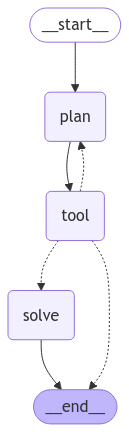

In [61]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### h. Invoke the Agentic System

In [62]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'steps': [("First, let's search for the winner of the 2024 Men's Australian Open to find out who it is. I will use Google to search for the latest information on the tournament outcome. ", '#E1', 'Google', '"2024 Men\'s Australian Open winner"'), ("Once I have identified the winner's name, I will perform a search to retrieve the hometown of that specific player. This will be done by querying Google again, this time using the winner's name. ", '#E2', 'Google', '"hometown of [winner\'s name from #E1'), ('Finally, I will confirm the information collected about the hometown by checking reliable sources to ensure accuracy. This may include returning to another Google search or checking the player’s official biography if available. ', '#E3', 'Google', '"[winner\'s name from #E1')], 'plan_string': 'To determine the exact hometown of the winner of the 2024 Men\'s Australian Open, we need to follow a detailed plan that includes gathering current information and confirming the winner\'

In [63]:
task = "what is the hometown of the men's football world cup 2022 - Golden ball winner?"

In [64]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'steps': [("Search for the name of the men's football World Cup 2022 Golden Ball winner. ", '#E1', 'Google', '"men\'s football World Cup 2022 Golden Ball winner"'), ('Once we have the name of the winner, look up their hometown or place of birth. ', '#E2', 'Google', '"hometown of #E1"'), ("Compile the information and provide a summary of the findings regarding the Golden Ball winner's hometown. ", '#E3', 'LLM', 'Summarize the hometown of the winner identified in #E2')], 'plan_string': 'To determine the hometown of the men\'s football World Cup 2022 Golden Ball winner, we first need to establish who the winner is, and then we can identify their hometown. The plan involves checking for the 2022 Golden Ball winner and finding their place of origin. Here\'s a step-by-step plan:\n\nPlan: Search for the name of the men\'s football World Cup 2022 Golden Ball winner. #E1 = Google["men\'s football World Cup 2022 Golden Ball winner"]\n\nPlan: Once we have the name of the winner, look up

In [65]:
task = "what is the hometown of the men's cricket T20 world cup 2024 - Man of the tournament winner?"

In [66]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'steps': [('Start by identifying the host country for the men\'s cricket T20 World Cup 2024, as it usually narrows down the possible candidates for the "Man of the Tournament" based on the participant teams and their performance. I will search for how the T20 World Cup 2024 is organized and who the host is. ', '#E1', 'Google', '"men\'s cricket T20 World Cup 2024 host country"'), ('Once I have the host country, I will need to search specifically for the "Man of the Tournament" winner for the men\'s cricket T20 World Cup 2024 once the tournament has concluded. Therefore, I will search for the outcome of the tournament and details about the awarded player. ', '#E2', 'Google', '"men\'s cricket T20 World Cup 2024 Man of the Tournament winner"'), ('Compile all the collected information to give a comprehensive answer including both the host country and the winner of the "Man of the Tournament" for context, ensuring that I clearly relate the winner to the 2024 tournament. ', '#E3', '